# Report Analysis
Save figures where possible using ```plt.savefig('image.png')```

Image ideas:
* Accuracy vs Partition number : performance 
* Runtime vs Partition number : speed
* Accuracy vs Runtime : trade-off
* Speed-up : scalability against serial implementation
* Confusion Matrices 
* (potentially Size-up / Scale-up)

Ensure the evaluation metrics identified in lit review reflect this. 

In [114]:
import os
import json
import pandas as pd
import numpy as np

def load_combined_report_dataframe(json_filename="report.json"):
    # Use relative path (assumes same directory)
    json_path = os.path.join(os.getcwd(), json_filename)

    with open(json_path, "r") as f:
        all_reports = json.load(f)

    records = []

    for key, report in all_reports.items():
        try:
            row_data = {}

            # Merge all relevant sections
            row_data.update(report.get("performance", {}))
            row_data.update(report.get("timing", {}))
            #row_data.update(report.get("memory", {}))
            row_data.update(report.get("complexity", {}))

            row_data["iteration"] = int(key)  # add the loop index for row label
            records.append(row_data)
        except Exception as e:
            print(f"Error processing report {key}: {e}")

    
    df = pd.DataFrame(records).set_index("iteration").sort_index()
    df = df.drop(columns=['model_type']) #Cannot be averaged as it is a string
    return df

local_unweighted = load_combined_report_dataframe('report_local_model_ALL_weighting_False_2025-05-05-01-16-39.json')
local_weighted = load_combined_report_dataframe('report_local_model_ALL_weighting_True_2025-05-05-01-33-22.json')
global_ = load_combined_report_dataframe('report_global_model_ALL_2025-05-04-17-28-05.json')

df_list = [local_weighted, local_unweighted, global_]
df_names = ['local_weighted', 'local_unweighted', 'global_']

for df in df_list:
    df['total time'] = df[[col for col in df.columns if col.endswith('_time')]].sum(axis=1)


## Plot all

In [115]:
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

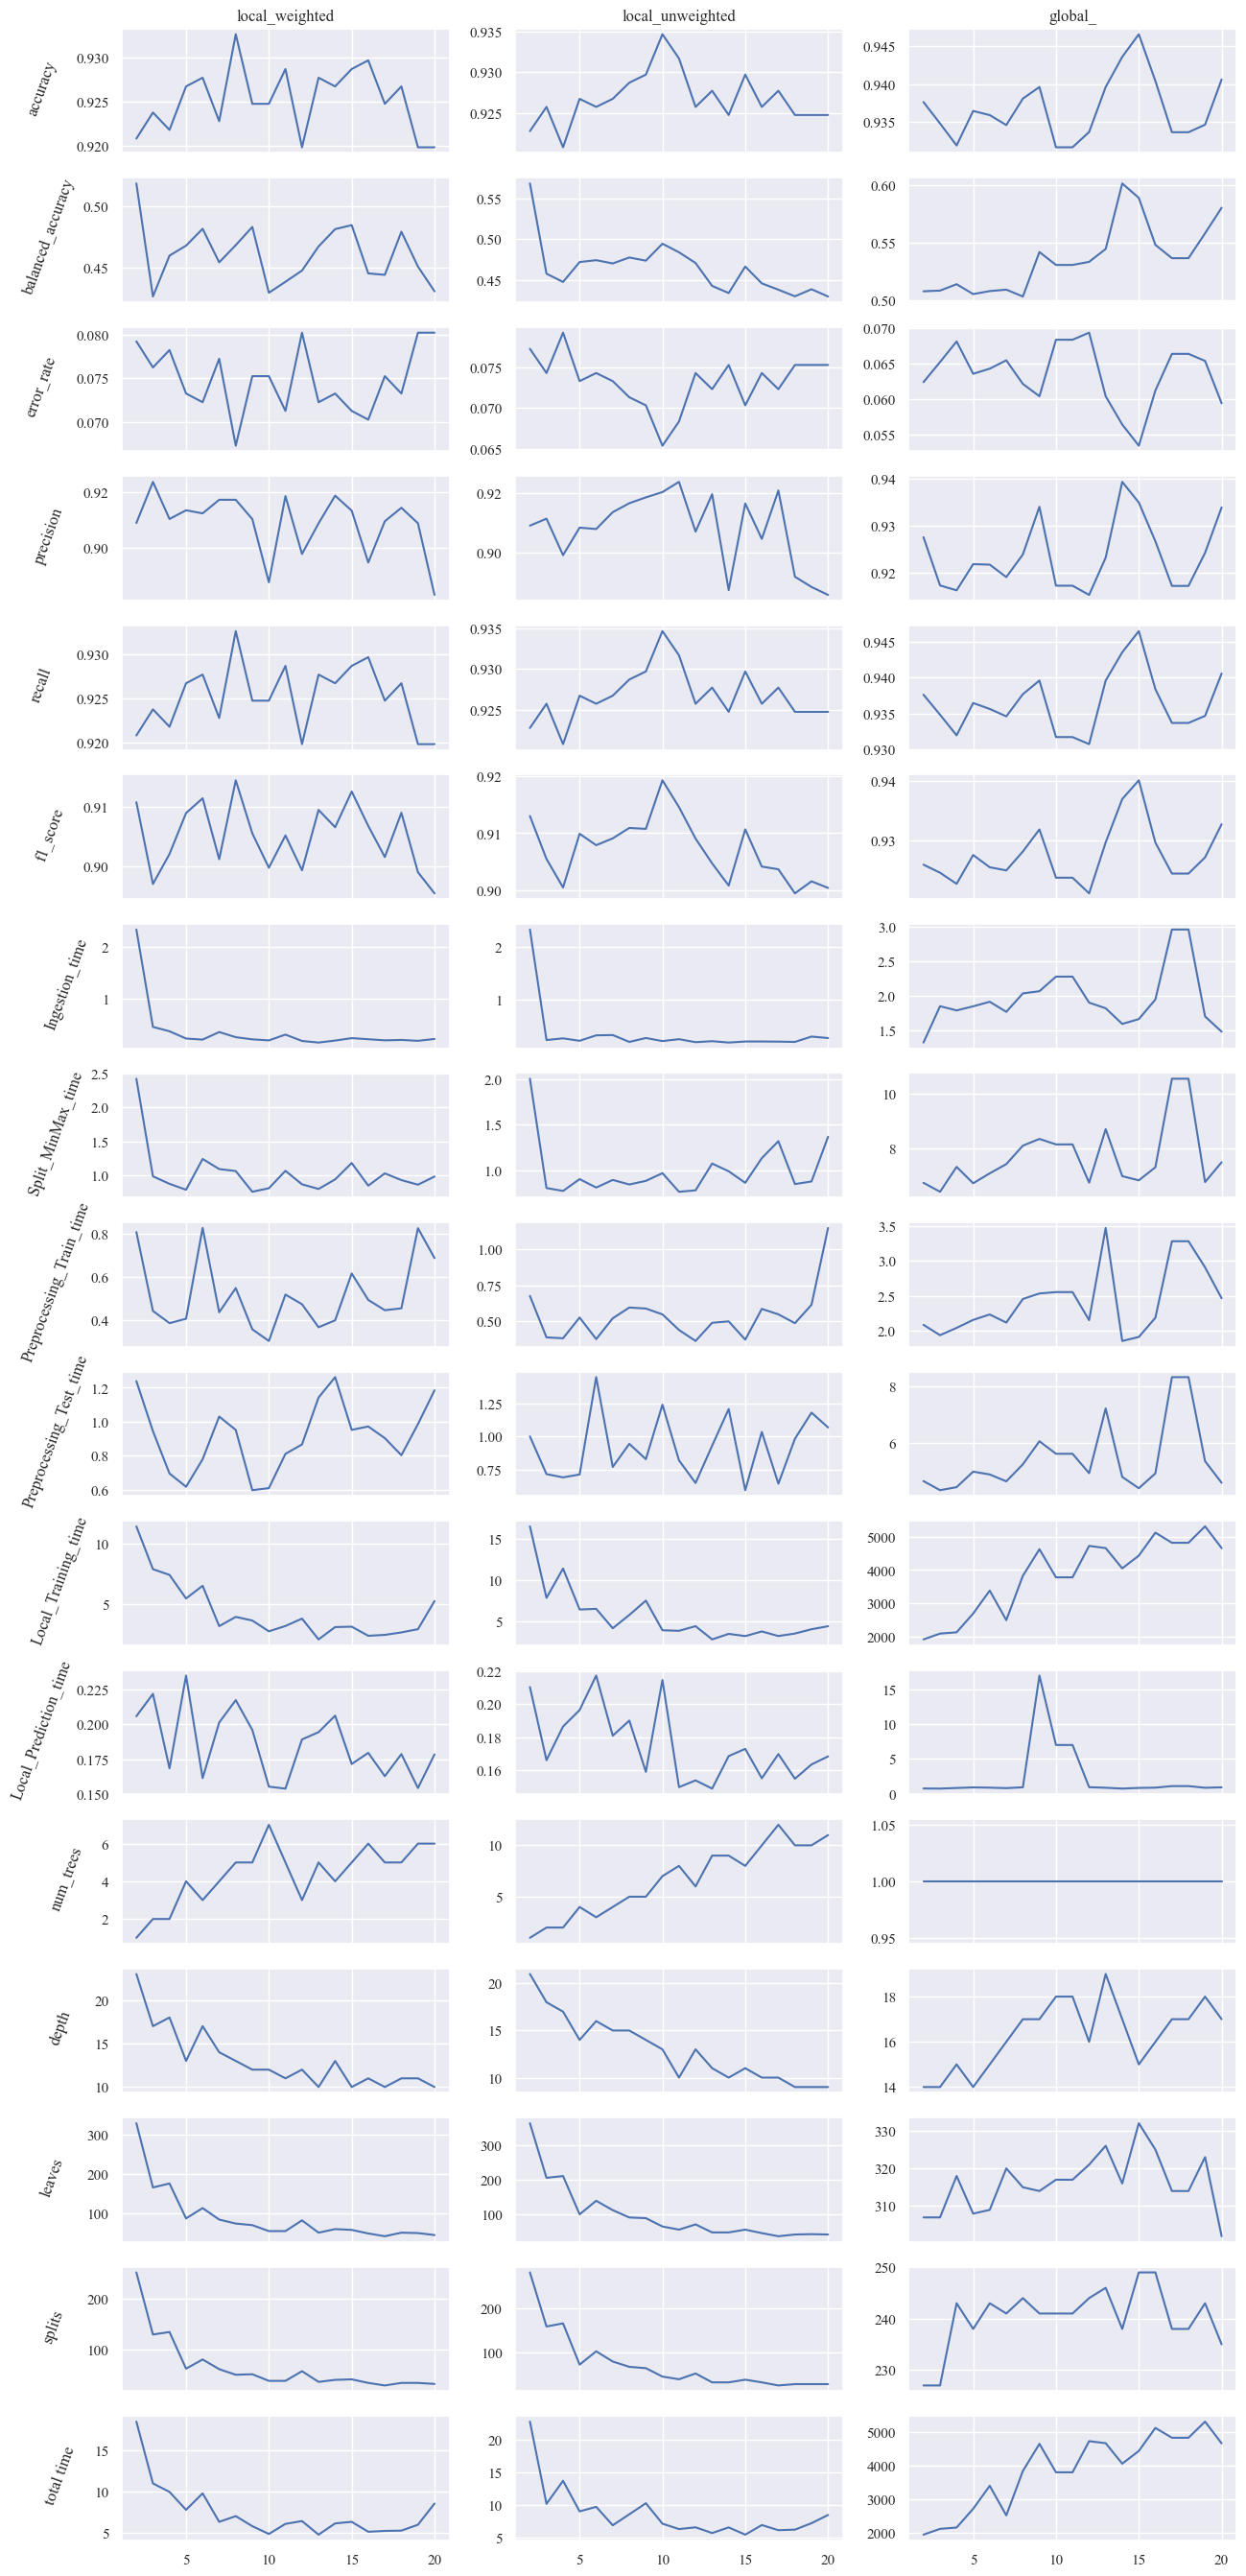

In [116]:
fig, ax = plt.subplots(nrows=len(df_list[0].columns), ncols=len(df_list), sharex=True, figsize=(len(df_list) * 5, len(df_list[0].columns) * 2))

for j, df in enumerate(df_list):
    for i, col in enumerate(df.columns):
        vals = df[col]
        ax[i, j].plot(vals.index, vals.values)
        if j == 0:
            ax[i, j].set_ylabel(col, rotation=70, labelpad=20)
        if i == 0:
            ax[i, j].set_title(f"{df_names[j]}", fontsize=12)

plt.savefig(f'img/metrics.png', dpi=300, bbox_inches='tight')

## Accuracy vs Partition number : Performance


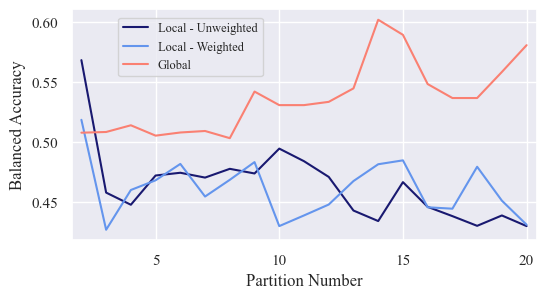

In [117]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

ax.plot(local_unweighted['balanced_accuracy'], color='midnightblue')       
ax.plot(local_weighted['balanced_accuracy'], color='cornflowerblue')
ax.plot(global_['balanced_accuracy'], color='salmon')
ax.set_ylabel(f"Balanced Accuracy")
ax.set_xlabel(f"Partition Number")
ax.set_xticks(np.linspace(5, 20, 4))
ax.set_xlim(1.6, 20.4)
ax.legend(['Local - Unweighted', 'Local - Weighted', 'Global'], loc=[0.1, 0.71], fontsize=9)

plt.savefig(f'img/balancedAccuracyVSpartition.png', dpi=1200, bbox_inches='tight')

## Runtime vs Partition number : Speed

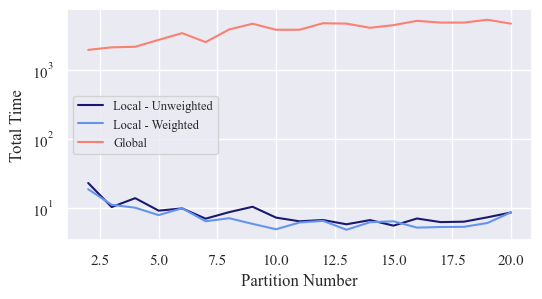

In [118]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

ax.plot(local_unweighted['total time'], color='midnightblue')       
ax.plot(local_weighted['total time'], color='cornflowerblue')
ax.plot(global_['total time'], color='salmon')

ax.set_ylabel(f"Total Time")
ax.set_xlabel(f"Partition Number")
ax.legend(['Local - Unweighted', 'Local - Weighted', 'Global'], loc='center left', fontsize=9)
ax.set_yscale('log')

plt.savefig(f'img/runtimeVSpartition.png', dpi=1200, bbox_inches='tight')

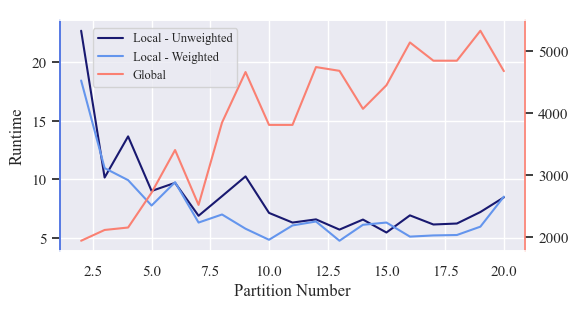

In [119]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

ax2 = ax1.twinx()
n_breaks = 5

ax1.plot(local_unweighted['total time'], color='midnightblue')
ax1.plot(local_weighted['total time'], color='cornflowerblue')
#ax1.set_ylim(4,18)
#ax1.set_yticks(np.linspace(4, 18, n_breaks))
ax1.set_ylabel("Runtime")
#ax1.tick_params(axis='y', labelcolor='midnightblue')

ax2.plot(global_['total time'], color='salmon')
#ax2.set_ylim(1200, 1900)

#ax2.set_yticks(np.linspace(1200, 1900, n_breaks))
#ax2.tick_params(axis='y', labelcolor='cornflowerblue')

ax2.spines['left'].set_color('royalblue')
ax2.spines['right'].set_color('salmon')
ax2.grid(None)
ax1.set_xlabel("Partition Number")

fig.legend(['Local - Unweighted', 'Local - Weighted', 'Global'], loc=[0.16, 0.72], fontsize=9)

plt.savefig(f'img/runtimeVSpartition-twinAx.png', dpi=1200, bbox_inches='tight')

## Accuracy vs Runtime : trade-off

Consider adding a line of best fit. 

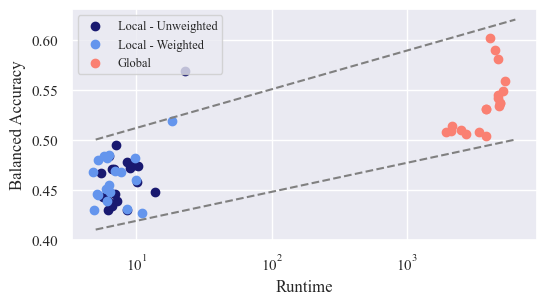

In [127]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

ax.scatter(local_unweighted['total time'], local_unweighted['balanced_accuracy'], color='midnightblue')
ax.scatter(local_weighted['total time'], local_weighted['balanced_accuracy'], color='cornflowerblue')
ax.scatter(global_['total time'], global_['balanced_accuracy'], color='salmon')
ax.plot(np.logspace(0.7, 3.8, 100), np.linspace(0.50, 0.62, 100), color='grey', linestyle='--')
ax.plot(np.logspace(0.7, 3.8, 100), np.linspace(0.41, 0.50, 100), color='grey', linestyle='--')
ax.set_ylabel(f"Balanced Accuracy")
ax.set_xlabel(f"Runtime")
ax.set_xscale('log')
ax.legend(['Local - Unweighted', 'Local - Weighted', 'Global'], loc='upper left', fontsize=9)

plt.savefig(f'img/balancedAccuracyVSruntime.png', dpi=1200, bbox_inches='tight')

## Speed-up - NEEDS WORK

Need to loop over changing processor number for this. 

In [121]:
local_unweighted_serial_speed = 17.2592 #seconds
local_weighted_serial_speed = 17.6431 #seconds
global_serial_speed = 1624.067 #seconds
local_unweighted['Speed_up'] = local_unweighted_serial_speed / local_unweighted['total time']
local_weighted['Speed_up'] = local_weighted_serial_speed / local_weighted['total time']
global_['Speed_up'] = global_serial_speed / global_['total time']

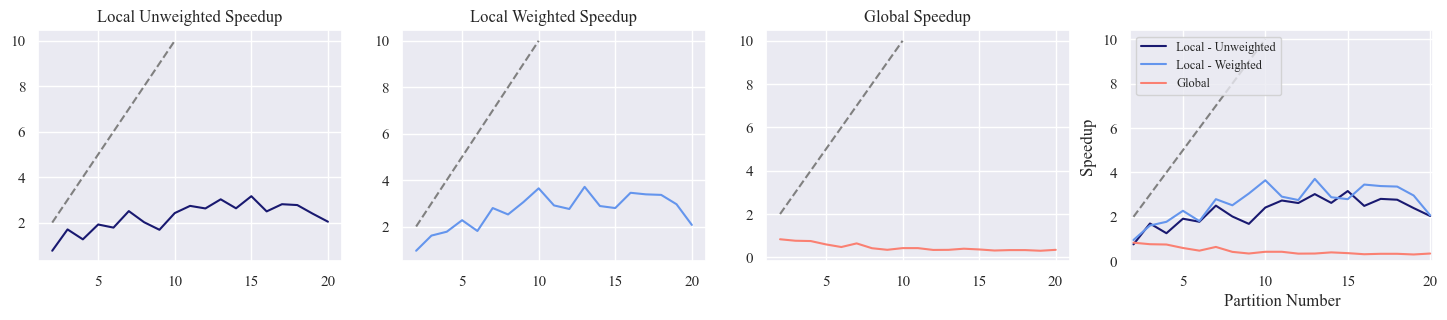

In [122]:
fig, ax = plt.subplots(1, 4, figsize=(18, 3))

ax[0].plot(local_unweighted['Speed_up'], color='midnightblue')
ax[0].plot(np.linspace(2, 10, 100), np.linspace(2, 10, 100), color='grey', linestyle='--')
ax[0].set_title('Local Unweighted Speedup')

ax[1].plot(local_weighted['Speed_up'], color='cornflowerblue')
ax[1].plot(np.linspace(2, 10, 100), np.linspace(2, 10, 100), color='grey', linestyle='--')
ax[1].set_title('Local Weighted Speedup')


ax[2].plot(global_['Speed_up'], color='salmon')
ax[2].plot(np.linspace(2, 10, 100), np.linspace(2, 10, 100), color='grey', linestyle='--')
ax[2].set_title('Global Speedup')

ax[3].plot(local_unweighted['Speed_up'], label='Local', color='midnightblue')
ax[3].plot(local_weighted['Speed_up'], label='Global', color='cornflowerblue')
ax[3].plot(global_['Speed_up'], label='Global', color='salmon')
ax[3].plot(np.linspace(2, 10, 100), np.linspace(2, 10, 100), color='grey', linestyle='--')
ax[3].legend(['Local - Unweighted', 'Local - Weighted', 'Global'], loc='upper left', fontsize=9)
ax[3].set_ylim(0, 10.4)
ax[3].set_xlim(1.8, 20.2)
ax[3].set_xlabel('Partition Number')
ax[3].set_ylabel('Speedup')

plt.savefig(f'img/speedup.png', dpi=1200, bbox_inches='tight')

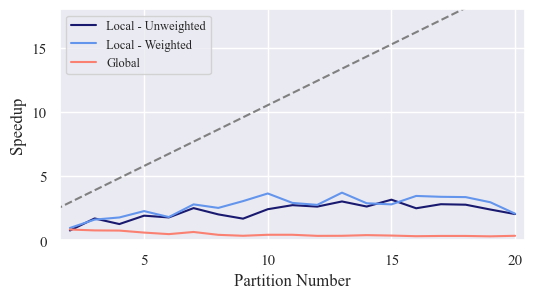

In [129]:
fig, ax = plt.subplots(1,1, figsize=(6, 3))
#ax.plot(np.linspace(2, 10, 100), np.linspace(1, 1, 100), color='lightgrey', linestyle='--')
ax.plot(local_unweighted['Speed_up'], label='Local - Unweighted', color='midnightblue')
ax.plot(local_weighted['Speed_up'], label='Local - Weighted', color='cornflowerblue')
ax.plot(global_['Speed_up'], label='Global', color='salmon')
ax.plot(np.linspace(1, 20, 100), np.linspace(2, 20, 100), color='grey', linestyle='--')
ax.legend(['Local - Unweighted', 'Local - Weighted', 'Global'], loc='upper left', fontsize=9)
ax.set_xlabel('Partition Number')
ax.set_ylabel('Speedup')
ax.set_ylim(0, 18)
ax.set_xticks(np.linspace(5, 20, 4))
ax.set_xlim(1.6, 20.4)


plt.savefig(f'img/speedupComparison.png', dpi=1200, bbox_inches='tight')